<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/week07/logistic_random_forest_or_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic, Random Forest, or KNN?
- Michael Vincent
- 8/3/22

## Imports

In [182]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Load the data

In [126]:
# Load the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRoqV0pKzYc2aiS-Oiy2rtEYrK0ocIRJrag3dWIEwSFoZ8RKLBzQsMUuyFe5U_rTXy7_8XinC626rYI/pub?output=csv'
df = pd.read_csv(url)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Explore the data

In [127]:
# Check for duplicates and missing values
print('Duplicates:', df.duplicated().sum())
print('Missing Values:', df.isna().sum().sum())

Duplicates: 0
Missing Values: 0


In [128]:
# Check the variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [129]:
# Diagnosis was the only string type. Check for inconsistent
# labels in diagnosis.
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

> We see from the above that this data set is not balanced between malignant and benign diagnoses.

## Prepare the data

In [130]:
# A malignant tumor will be our positive class.
df['diagnosis'].replace({'B': 0, 'M': 1}, inplace = True)

In [131]:
# Set the features and target
X = df.drop(columns = 'diagnosis')
y = df['diagnosis']

In [132]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Logistic regression

### Default model

In [133]:
# Construct a defualt logistic regression model
logreg = make_pipeline(StandardScaler(), LogisticRegression())
logreg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [134]:
# Score the default model
print('Score on training set:', logreg.score(X_train, y_train))
print('Score on test set:', logreg.score(X_test, y_test))

Score on training set: 0.9882629107981221
Score on test set: 0.9790209790209791


In [135]:
# Evaluate metrics on the test set
predictions = logreg.predict(X_test)
print('Accuracy of default logistic model on the test set:', accuracy_score(y_test, predictions))
print('Recall of default logistic model on the test set:', recall_score(y_test, predictions))
print('Precision of default logistic model on the test set:', precision_score(y_test, predictions))

Accuracy of default logistic model on the test set: 0.9790209790209791
Recall of default logistic model on the test set: 0.9814814814814815
Precision of default logistic model on the test set: 0.9636363636363636


> The recall score on our default logistic model is higher than the precision. So we expect fewer false negatives than false positives. This is desirable for our model as we want to minimize cases of undetected cancer.

### L1 tuning

In [136]:
# Construct a logistic model using l1 tuning.

# Construct a list of C values and create 
# lists to store the scores
c_values = np.float_power(10, range(-4,4))
train_scores = []
test_scores = []
test_recall_scores = []
test_precision_scores = []

# Loop through the C values
for c in c_values:
  # Construct the pipeline
  logreg = LogisticRegression(C = c, max_iter = 1000, solver = 'liblinear', penalty = 'l1')
  logreg_pipe = make_pipeline(StandardScaler(), logreg)
  logreg_pipe.fit(X_train, y_train)
  predictions = logreg_pipe.predict(X_test)

  # Score the model
  train_scores.append(logreg_pipe.score(X_train, y_train))
  test_scores.append(logreg_pipe.score(X_test, y_test))
  test_recall_scores.append(recall_score(y_test, predictions))
  test_precision_scores.append(precision_score(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy
{0.0001: 0.6223776223776224, 0.001: 0.6223776223776224, 0.01: 0.951048951048951, 0.1: 0.972027972027972, 1.0: 0.972027972027972, 10.0: 0.9440559440559441, 100.0: 0.9370629370629371, 1000.0: 0.9370629370629371}

Test Recall
{0.0001: 0.0, 0.001: 0.0, 0.01: 1.0, 0.1: 0.9629629629629629, 1.0: 0.9814814814814815, 10.0: 0.9814814814814815, 100.0: 0.9814814814814815, 1000.0: 0.9814814814814815}

Test Precision
{0.0001: 0.0, 0.001: 0.0, 0.01: 0.8852459016393442, 0.1: 0.9629629629629629, 1.0: 0.9464285714285714, 10.0: 0.8833333333333333, 100.0: 0.8688524590163934, 1000.0: 0.8688524590163934}


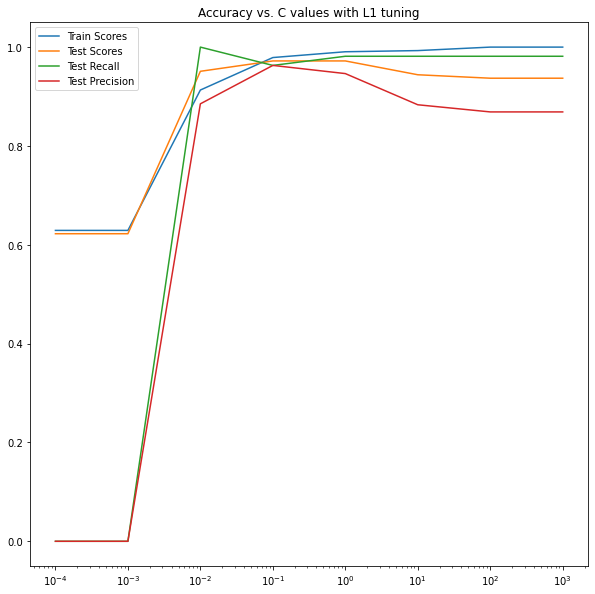

In [137]:
# Graph the scores
fig, ax = plt.subplots(1, 1, figsize = (10, 10));
ax.plot(c_values, train_scores, label = 'Train Scores');
ax.plot(c_values, test_scores, label = 'Test Scores');
ax.plot(c_values, test_recall_scores, label = 'Test Recall');
ax.plot(c_values, test_precision_scores, label = 'Test Precision')
ax.set_xticks(c_values);
ax.set_xscale('log');
ax.set_title('Accuracy vs. C values with L1 tuning')
ax.legend();

# Display a dictionary of scores
print('Test Accuracy')
print({c:score for c, score in zip(c_values, test_scores)})
print('\nTest Recall')
print({c:score for c, score in zip(c_values, test_recall_scores)})
print('\nTest Precision')
print({c:score for c, score in zip(c_values, test_precision_scores)})

### L2 tuning

In [138]:
# Construct a logistic model using l2 tuning.

# Construct a list of C values and create 
# lists to store the scores
c_values = np.float_power(10, range(-4,4))
train_scores = []
test_scores = []
test_recall_scores = []
test_precision_scores = []

# Loop through the C values
for c in c_values:
  # Construct the pipeline
  logreg = LogisticRegression(C = c, max_iter = 1000, solver = 'liblinear', penalty = 'l2')
  logreg_pipe = make_pipeline(StandardScaler(), logreg)
  logreg_pipe.fit(X_train, y_train)
  predictions = logreg_pipe.predict(X_test)

  # Score the model
  train_scores.append(logreg_pipe.score(X_train, y_train))
  test_scores.append(logreg_pipe.score(X_test, y_test))
  test_recall_scores.append(recall_score(y_test, predictions))
  test_precision_scores.append(precision_score(y_test, predictions))

Test Accuracy
{0.0001: 0.951048951048951, 0.001: 0.951048951048951, 0.01: 0.9790209790209791, 0.1: 0.993006993006993, 1.0: 0.9790209790209791, 10.0: 0.972027972027972, 100.0: 0.951048951048951, 1000.0: 0.9230769230769231}

Test Recall
{0.0001: 0.9629629629629629, 0.001: 0.9629629629629629, 0.01: 0.9814814814814815, 0.1: 0.9814814814814815, 1.0: 0.9814814814814815, 10.0: 0.9814814814814815, 100.0: 0.9814814814814815, 1000.0: 0.9814814814814815}

Test Precision
{0.0001: 0.9122807017543859, 0.001: 0.9122807017543859, 0.01: 0.9636363636363636, 0.1: 1.0, 1.0: 0.9636363636363636, 10.0: 0.9464285714285714, 100.0: 0.8983050847457628, 1000.0: 0.8412698412698413}


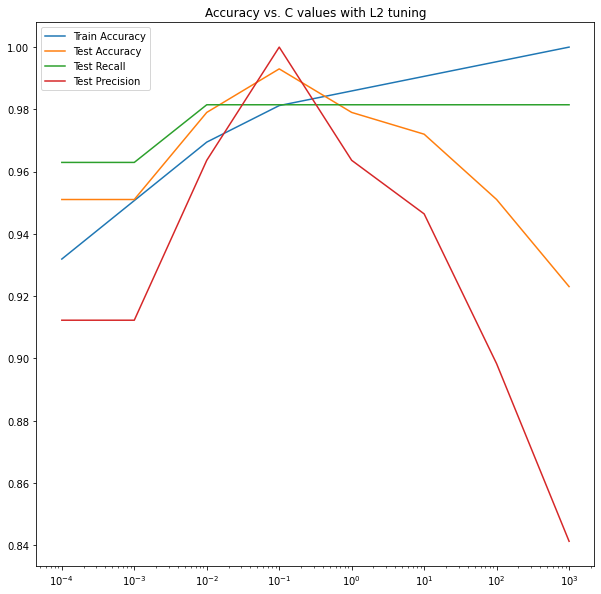

In [139]:
# Graph the scores
fig, ax = plt.subplots(1, 1, figsize = (10, 10));
ax.plot(c_values, train_scores, label = 'Train Accuracy');
ax.plot(c_values, test_scores, label = 'Test Accuracy');
ax.plot(c_values, test_recall_scores, label = 'Test Recall');
ax.plot(c_values, test_precision_scores, label = 'Test Precision')
ax.set_xticks(c_values);
ax.set_xscale('log');
ax.set_title('Accuracy vs. C values with L2 tuning')
ax.legend();

# Display a dictionary of scores
print('Test Accuracy')
print({c:score for c, score in zip(c_values, test_scores)})
print('\nTest Recall')
print({c:score for c, score in zip(c_values, test_recall_scores)})
print('\nTest Precision')
print({c:score for c, score in zip(c_values, test_precision_scores)})


>Our best logistic model used L2 tuning with a C value of 0.1. It got the following scores.
- Accuracy: 0.993
- Recall: 0.981
- Precission: 1.0

> While we would prefer a greater recall than precision, we are happy with the overall performance of this model.

## K nearest neighbors model

### Default model

In [145]:
# Construct a default k nearest neighbors model
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [155]:
# Score the default model
knn_predictions = knn_pipe.predict(X_test)
print('Accuracy of default knn model:', knn_pipe.score(X_test, y_test))
print('Recall of default knn model:', recall_score(y_test, knn_predictions))
print('Precision of default knn model:', precision_score(y_test, knn_predictions))

Accuracy of default knn model: 0.958041958041958
Recall of default knn model: 0.9444444444444444
Precision of default knn model: 0.9444444444444444


> As we can see our default k-nearest neighbors model does not scores as highly as our default logistic regression model. We will try tuning the k-nearest neighbors model using GridSearchCV.

### Tune the k-nearest neighbors model with GridSearchCV

In [157]:
# Get the hyper parameters of our default model
knn_pipe.get_params()

{'kneighborsclassifier': KNeighborsClassifier(),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform',
 'memory': None,
 'standardscaler': StandardScaler(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False}

In [178]:
# Make a dictionary of parameters to tune.
grid_param = {'kneighborsclassifier__n_neighbors': range(1, 20),
              'kneighborsclassifier__p': range(1, 10),
              'kneighborsclassifier__weights': ['distance', 'uniform']}

In [179]:
# Tune the model
knn_pipe_gs = GridSearchCV(knn_pipe, grid_param)
knn_pipe_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 20),
                         'kneighborsclassifier__p': range(1, 10),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']})

In [180]:
# Get the best parameters
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)

# Get the best model
best_knn = knn_pipe_gs.best_estimator_

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 4, 'kneighborsclassifier__weights': 'distance'}


In [181]:
# Evaluate the best model
knn_predictions = best_knn.predict(X_test)
print('Accuray of best KNN model:', best_knn.score(X_test, y_test))
print('Recall of best KNN model:', recall_score(y_test, knn_predictions))
print('Precision of best KNN model:', precision_score(y_test, knn_predictions))

Accuray of best KNN model: 0.951048951048951
Recall of best KNN model: 0.9259259259259259
Precision of best KNN model: 0.9433962264150944


## Random forest model

### Default model

In [186]:
# Construct a default random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [189]:
# Evaluate the default model
rf_predictions = rf.predict(X_test)
print('Accuracy of default random forest:', rf.score(X_test, y_test))
print('Recall of default random forest:', recall_score(y_test, rf_predictions))
print('Precision of default random forest:', precision_score(y_test, rf_predictions))

Accuracy of default random forest: 0.965034965034965
Recall of default random forest: 0.9444444444444444
Precision of default random forest: 0.9622641509433962


> The default random forest performs slightly better than the default knn, but does not outperform logistic regression. We will tune the random forest using GridSearchCV

### Tune the random forest using GridSearchCV

In [200]:
# Get the hyperparameters for the random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [219]:
# Construct a grid_param dictionary
param_grid = {'max_depth': range(1, 10),
              'min_samples_leaf': range(1, 5),
              'min_samples_split': [2, 8, 16]}

In [220]:
# Tune the random forest 
rf_grid_search = GridSearchCV(rf, param_grid)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': [2, 8, 16]})

In [221]:
# Get the best parameters
rf_grid_search.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [222]:
# Get the best model
best_rf = rf_grid_search.best_estimator_

In [223]:
# Evaluate the best model on the test set
rf_predictions = best_rf.predict(X_test)
print('Accuray of the random forest:', best_rf.score(X_test, y_test))
print('Recall of the random forest:', recall_score(y_test, rf_predictions))
print('Precision of the random forest:', precision_score(y_test, rf_predictions))

Accuray of the random forest: 0.972027972027972
Recall of the random forest: 0.9444444444444444
Precision of the random forest: 0.9807692307692307
